In [2]:
import os
import numpy as np
import pandas as pd
os.environ["NAMESPACE"]="research"
os.environ["PROFILE"]="local"
from agrobrain_util.runtime.evironment import RuntimeEnv
from agrobrain_util.infra.app_config import application_config as cfg

import shutil
import glob
from skimage import io
import matplotlib.pyplot as plt
import json
import random
import glob
import datetime
from tqdm import tqdm
from datetime import datetime

from PIL import Image


env = RuntimeEnv()
categories_dict = cfg['tags']['categories']

# DATA_DIR = r"C:/Users/Anafa/data/agrobrain_wide_images_exploration"
# DATA_DIR = "C:\\Users\\Anafa\\data\\agrobrain_wide_images_exploration"
DATA_DIR = "data"

could not find stamp in environment variables
could not find stamp in environment variables
could not find KUBEFLOW_API_BASIC_AUTH_TOKEN in environment variables
could not find AI_RABBITMQ_CONNECTION_STRING in environment variables
could not find AI_MONGO_DB_CONNECTION_STRING in environment variables
could not find TARANIS_DB_CONNECTION_STRING in environment variables
could not find GLOBAL_DB_CONNECTION_STRING in environment variables
could not find AI_MONGO_DB_CONNECTION_STRING_NEW in environment variables


In [5]:
# INITIALIZE - READ WEEDS_IMAGES_DF, FILTERED_IMAGES_DF, CREATE CATEGORIES DICTIONARY
def get_wide_images_list(current_df):
    l  = []
    for i in tqdm(range(0, len(current_df['imageID']), 10)):
        # print(current_df['imageID'][i])
        wide_image_id = env.eti_api.get_matching_wide_images(list(current_df['imageID'][i:i+10]))
        # print(wide_image_id)
        l.append(wide_image_id)
    wide_images_list = [item for sublist in l for item in sublist]
    return wide_images_list

def create_cat_dict(cat_list):
    cat_dict_types = {}
    cat_dict_names = {}
    for l in cat_list:
        cat_dict_types[l['id']] = l['type']
        if 'name' in l:
            cat_dict_names[l['id']] = l['name']
        else:
            cat_dict_names[l['id']] = 'NoName'
    cat_dict_types[0] = None
    cat_dict_names[0] = None
    return cat_dict_types, cat_dict_names

# # READ FILTERED DATAFRAME - ONLY THE IMAGES THAT CONTAINES WEEDS. ADDING WEEDS DATA LIKE TYPE IDS, NAME, COVARAGE
# # weeds_images_df = pd.read_csv("/mnt/disks/datasets/wide_images/weeds_images_df.csv")
weeds_images_df = pd.read_csv(os.path.join(DATA_DIR, "weeds_images_df_light.csv"))

weeds_images_df['weed_types_ids_list'] = weeds_images_df['weed_types_ids_list'].apply(eval)
weeds_images_df['uploadDate_time'] = weeds_images_df['uploadDate'].apply(datetime.fromtimestamp)
weeds_images_df['uploadDate_date'] = weeds_images_df['uploadDate_time'].apply(lambda x: x.to_pydatetime().date())
filtered_weeds_images_df = weeds_images_df[(weeds_images_df['cameraAngle'] > -95) & (weeds_images_df['cameraAngle'] < -85)]
images_df = filtered_weeds_images_df
weeds_images_df = 0
filtered_weeds_images_df = 0


# # READ FILTERED DF, ADD SOME COLUMNS
# top_weeds_df = pd.read_csv('/mnt/disks/datasets/wide_images/filtered_weeds_df.csv')
# top_weeds_df = pd.read_csv(os.path.join(DATA_DIR, "filtered_weeds_df.csv"))

# top_weeds_df['uploadDate_time'] = top_weeds_df['uploadDate'].apply(datetime.fromtimestamp)
# top_weeds_df['uploadDate_date'] = top_weeds_df['uploadDate_time'].apply(lambda x: x.to_pydatetime().date())
# top_weeds_df['weed_types_ids_list'] = top_weeds_df['weed_types_ids_list'].apply(eval)
# top_weeds_df['num_weed_types'] = top_weeds_df['weed_types_ids_list'].apply(len)


# CREATE CATEGORIES DICTIONARY
categories_hierarchy = env.eti_api.get_categories_hierarchy()
cat_dict_types, cat_dict_names = create_cat_dict(categories_hierarchy[9]['subCategories'])

# # GET UNIQUE VALUES OF WEED TYPES
# unique_weed_types_ids, count_unique_weed_types = np.unique(images_df['weed_types_ids_list'].explode(), return_counts=True)
# unique_weed_types_names = [cat_dict_names[id] for id in unique_weed_types_ids]

In [3]:
# FITER "ONE WEED TYPE" DATAFRAME AND ADD RELEVANT FEATURES

images_df['num_weed_types'] = images_df['weed_types_ids_list'].apply(len)
one_weed_type_df = images_df[images_df['num_weed_types']==1].reset_index(drop=True)
one_weed_type_df['weed_types_ids'] = one_weed_type_df['weed_types_ids_list'].apply(lambda x: x[0])
one_weed_type_df['weed_inferenceTagsCount'] = one_weed_type_df['weed_inferenceTagsCount'].apply(eval)
one_weed_type_df['weed_inferenceTagsCount'] = one_weed_type_df['weed_inferenceTagsCount'].apply(lambda x: x[0])
one_weed_type_df['weed_manualTagsCount'] = one_weed_type_df['num_weed_tags'] - one_weed_type_df['weed_inferenceTagsCount']

filtered_one_weed_type_df = one_weed_type_df[one_weed_type_df['num_weed_tags'] > 20]

In [ ]:
# np.max(one_weed_type_df['weed_inferenceTagsCount']), np.max(one_weed_type_df['weed_manualTagsCount'])

In [ ]:
# NORMALIZE AMOUNT OF TAGS
# INFERENCE
min_val_inf = filtered_one_weed_type_df['weed_inferenceTagsCount'].min()
max_val_inf = filtered_one_weed_type_df['weed_inferenceTagsCount'].max()
filtered_one_weed_type_df['weed_inferenceTagsCount_normalized'] = (filtered_one_weed_type_df['weed_inferenceTagsCount'] - min_val_inf) / (max_val_inf - min_val_inf)

# MANUAL
min_val_manual = filtered_one_weed_type_df['weed_manualTagsCount'].min()
max_val_manual = filtered_one_weed_type_df['weed_manualTagsCount'].max()
filtered_one_weed_type_df['weed_manualTagsCount_normalized'] = (filtered_one_weed_type_df['weed_manualTagsCount'] - min_val_manual) / (max_val_manual - min_val_manual)

In [ ]:
#SHOW HISTOGRAMS
colors = ['skyblue', 'plum']
names = [f'weed_inferenceTagsCount', f'weed_manualTagsCount']

plt.hist([filtered_one_weed_type_df['weed_inferenceTagsCount_normalized'], filtered_one_weed_type_df['weed_manualTagsCount_normalized']], histtype='bar',
                color=colors, label=names, density=False, bins = 100);
plt.xlabel('# weed tags')
plt.legend()
plt.show()

In [ ]:
# # GET INFORMATION ABOUT WEED TYPES (ONE WEED DATAFRAME)
# unique_weed_types, count_unique_weed_types = np.unique(one_weed_type_df['weed_types_ids_list'].explode(), return_counts=True)
# unique_weed_types, count_unique_weed_types = np.unique(one_weed_type_df['weed_types_ids'], return_counts=True)

# interesting_weed_types = unique_weed_types[np.argsort(count_unique_weed_types)[:-4]]
# interesting_weed_names = np.vectorize(cat_dict_names.get)(interesting_weed_types)
# interesting_weed_df = one_weed_type_df[one_weed_type_df['weed_types_ids'].isin(interesting_weed_types)].reset_index()
# interesting_weed_df['wideImageID'] = get_wide_images_list(interesting_weed_df)
# interesting_weed_df = interesting_weed_df.sort_values('num_weed_tags', ascending=False).reset_index()

# interesting_weed_df.to_csv(os.path.join(DATA_DIR, "interesting_weed_df.csv"))

In [ ]:
# # CREATE DATAFRAME WITH SMALL AMOUNT OF TAGS ~20

# corn_df = one_weed_type_df[one_weed_type_df['cropName']=='Corn'].reset_index(drop=True)
# soy_df = one_weed_type_df[one_weed_type_df['cropName']=='Soybean'].reset_index(drop=True)


# small_num_of_tags_df_corn = corn_df[(corn_df['num_weed_tags']<21) & (corn_df['num_weed_tags']>19)].reset_index(drop=True)
# # small_num_of_tags_df_corn = corn_df[(corn_df['num_weed_tags']<21) & (corn_df['num_weed_tags']>19)].sample(n=10).reset_index(drop=True)
# small_num_of_tags_df_corn['wideImageID'] = get_wide_images_list(small_num_of_tags_df_corn)
# small_num_of_tags_df_soy = soy_df[(soy_df['num_weed_tags']<21) & (soy_df['num_weed_tags']>19)].reset_index(drop=True)
# # small_num_of_tags_df_soy = soy_df[(soy_df['num_weed_tags']<21) & (soy_df['num_weed_tags']>19)].sample(n=10).reset_index(drop=True)
# small_num_of_tags_df_soy['wideImageID'] = get_wide_images_list(small_num_of_tags_df_soy)

# small_num_of_tags_df_soy.to_csv(os.path.join(DATA_DIR, "small_num_of_tags_df_soy.csv"))
# small_num_of_tags_df_corn.to_csv(os.path.join(DATA_DIR, "small_num_of_tags_df_corn.csv"))

In [ ]:
# CREATE "SAMPLED DATAFRAME" OF VOLUNTEER CORN IN SOY FIELDS AND SORT BU DESCENDING ORDER OF NUM_WEED_TAGS

def get_key_by_value(d):
    for key, val in d.items():
        if val == 'Volunteer corn':
            return key
    return None

volunteer_corn_type_id = get_key_by_value(cat_dict_names)


# soy_df = one_weed_type_df[one_weed_type_df['cropName']=='Soybean'].reset_index()
# soy_with_volunteer_corn_df = soy_df[soy_df['weed_types_ids'] == volunteer_corn_type_id]
# soy_with_volunteer_corn_df['wideImageID'] = get_wide_images_list(soy_with_volunteer_corn_df)
# soy_with_volunteer_corn_df_sorted = soy_with_volunteer_corn_df.sort_values('num_weed_tags', ascending=False).reset_index()

# soy_with_volunteer_corn_df_sorted_csv_path = os.path.join(DATA_DIR, "soy_with_volunteer_corn_df_sorted.csv")
# soy_with_volunteer_corn_df_sorted.to_csv(soy_with_volunteer_corn_df_sorted_csv_path)

# # SAME WITH VOLUNTEER CORN IN CORN FIELD

# corn_df = one_weed_type_df[one_weed_type_df['cropName']=='Corn'].reset_index()
# corn_with_volunteer_corn_df = corn_df[corn_df['weed_types_ids'] == volunteer_corn_type_id]
# corn_with_volunteer_corn_df_sorted = corn_with_volunteer_corn_df.sort_values('num_weed_tags', ascending=False)[:100].reset_index()
# corn_with_volunteer_corn_df_sorted['wideImageID'] = get_wide_images_list(corn_with_volunteer_corn_df_sorted)


# corn_with_volunteer_corn_df_sorted_csv_path = os.path.join(DATA_DIR, "corn_with_volunteer_corn_df_sorted.csv")
# corn_with_volunteer_corn_df_sorted.to_csv(corn_with_volunteer_corn_df_sorted_csv_path)

soy_with_volunteer_corn_df = pd.read_csv(os.path.join(DATA_DIR, "soy_with_volunteer_corn_df_sorted.csv"))
corn_with_volunteer_corn_df = pd.read_csv(os.path.join(DATA_DIR, "corn_with_volunteer_corn_df_sorted.csv"))


In [ ]:
# # CREATE "SAMPLED DATAFRAME" BY UNIFORM SAMPLING THE DISTRIBUTION OF "NUM WEED TAGS" - MANUALLY AND INFERENCE

# def get_sampled_df(current_df, name='', n=20):
#     weights_manual_tags = current_df['weed_manualTagsCount'] / current_df['weed_manualTagsCount'].sum()
#     weights_inference_tags = current_df['weed_inferenceTagsCount'] / current_df['weed_inferenceTagsCount'].sum()

#     sampled_df_manual = current_df.sample(n=n, weights=weights_manual_tags, replace=False).reset_index()
#     sampled_df_inference = current_df.sample(n=n, weights=weights_inference_tags, replace=False).reset_index()

#     sampled_df = pd.concat([sampled_df_manual, sampled_df_inference])
#     sampled_df['wideImageID'] = get_wide_images_list(sampled_df)

#     fig, axes = plt.subplots(nrows=1, ncols=2)
#     axes[0].hist(sampled_df['num_weed_tags'], bins = 200, color='c')
#     axes[0].set_title(f"sampled {name} dataframe num_weed_tags")

#     axes[1].hist(current_df['num_weed_tags'], bins = 200, color='c')
#     axes[1].set_title(f"full {name} images dataframe num_weed_tags")

#     fig.set_size_inches(10, 5)
#     plt.tight_layout()
#     plt.show()
#     return sampled_df


# N = 30
# corn_df = one_weed_type_df[one_weed_type_df['cropName']=='Corn'].reset_index()
# corn_sampled_df = get_sampled_df(corn_df, name='corn', n=N)

# soy_df = one_weed_type_df[one_weed_type_df['cropName']=='Soybean'].reset_index()
# soy_sampled_df = get_sampled_df(soy_df, name='soy', n=N)

# sampled_df = pd.concat([corn_sampled_df, soy_sampled_df])

# sampled_df_csv_path = os.path.join(DATA_DIR, f"sampled_df_by_crop_types_and_weight_sample_manual_and_inference_tag_count_{N}_from_each.csv")
# sampled_df.to_csv(sampled_df_csv_path)


In [ ]:
# # CREATE "SAMPLED DATAFRAME" BY UNIFORM SAMPLING THE DISTRIBUTION OF "NUM WEED TAGS"

# weights = weeds_images_df['num_weed_tags'] / weeds_images_df['num_weed_tags'].sum()
# sampled_df = weeds_images_df.sample(n=100, weights=weights, replace=False).reset_index()
# sampled_df['wideImageID'] = get_wide_images_list(sampled_df)

# fig, axes = plt.subplots(nrows=1, ncols=2)
# axes[0].hist(sampled_df['num_weed_tags'], bins = 200, color='c')
# axes[0].set_title("sampled dataframe num_weed_tags")

# axes[1].hist(weeds_images_df['num_weed_tags'], bins = 200, color='c')
# axes[1].set_title("full images dataframe num_weed_tags")

# fig.set_size_inches(10, 5)
# plt.tight_layout()
# plt.show()

In [18]:
# final_df = pd.DataFrame(columns = sampled_df.columns)
# final_df['image_reasoning'] = None

In [47]:
# AFTER CHECKING WITH THE BOX BELOW, ADDING "DF_TO_SHOW" TO THE FINAL DATAFRAME

# final_df = pd.DataFrame(columns = sampled_df.columns)
# final_df['image_reasoning'] = None

# final_df_test = pd.read_csv(os.path.join(DATA_DIR, "weeds_chosen_wide_images.csv"))
# len(final_df_test)
# final_df = final_df_test


# final_df = pd.concat([final_df, df_to_show], ignore_index=True)
# len(final_df), len(df_to_show)

# final_df.to_csv(os.path.join(DATA_DIR, "weeds_chosen_wide_images_full.csv"))

# df_to_dataloop = pd.read_csv(os.path.join(DATA_DIR, "weeds_chosen_wide_images_full.csv"))


Zoom image id: 7439536
Wide image id: 7440277


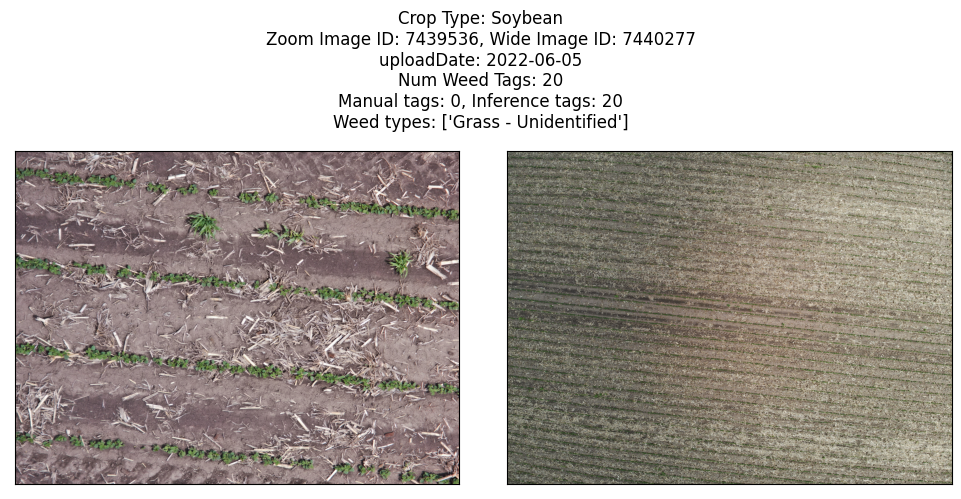

Zoom image id: 6177590
Wide image id: 6178664


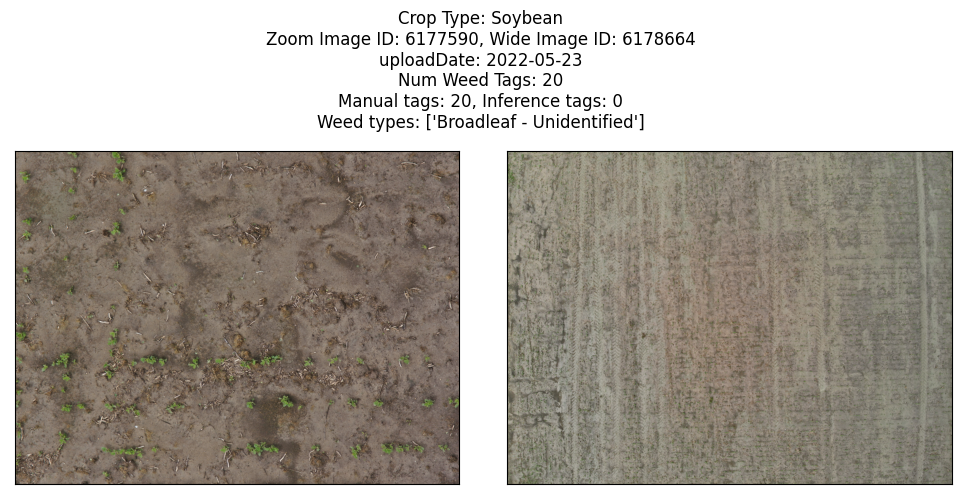

Zoom image id: 7726777
Wide image id: 7727233


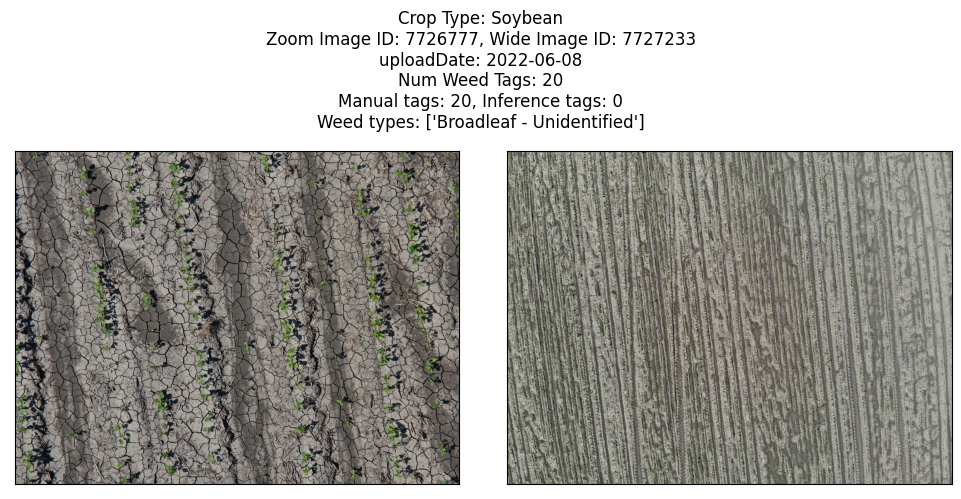

Zoom image id: 6239449
Wide image id: 6244444


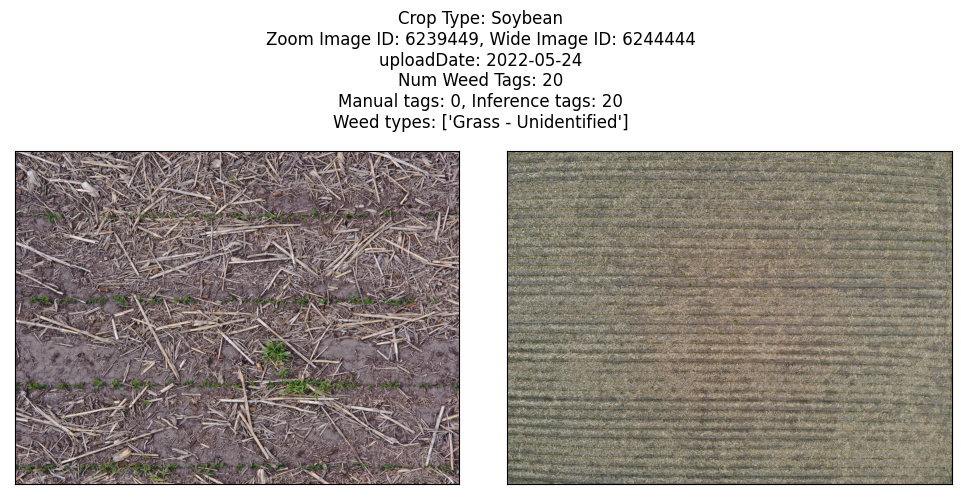

Zoom image id: 7058053
Wide image id: 7061492


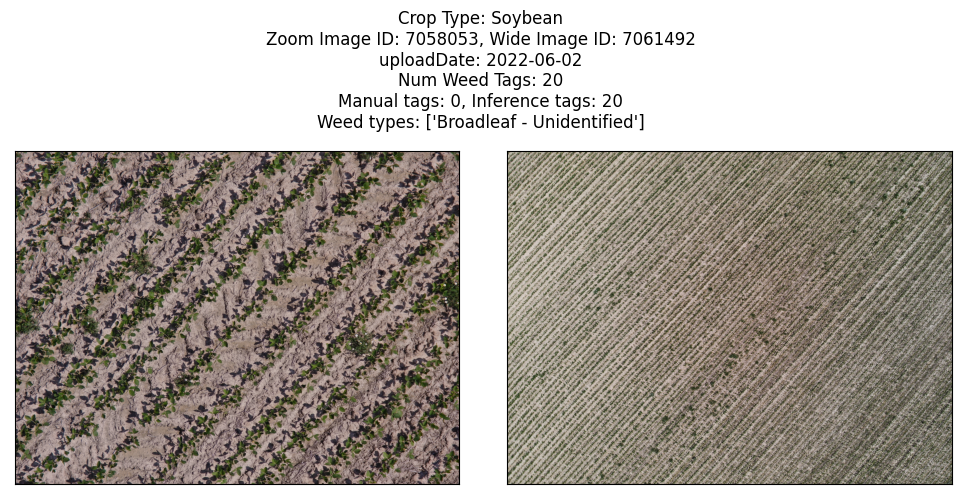

Zoom image id: 9379151
Wide image id: 9383779


: 

: 

In [58]:
# SHOW ZOOM-WIDE COUPLE OF IMAGES FROM THE DATAFRAME


def prepare_df(df):
    df['weed_types_ids'] = df['weed_types_ids_list'].apply(lambda x: x[0])
    # df['weed_inferenceTagsCount'] = df['weed_inferenceTagsCount'].apply(eval)
    # df['weed_inferenceTagsCount'] = df['weed_inferenceTagsCount'].apply(lambda x: x[0])
    df['weed_manualTagsCount'] = df['num_weed_tags'] - df['weed_inferenceTagsCount']
    return df


# # CHOOSE EXAMPLE IMAGE
# soybean_df = top_weeds_df[top_weeds_df['cropName']=='Soybean'].reset_index()
# earliest_soy_images = soybean_df[soybean_df['uploadDate_date'] == soybean_df['uploadDate_date'].min()].reset_index()
# latest_soy_images = soybean_df[soybean_df['uploadDate_date'] == soybean_df['uploadDate_date'].max()].reset_index()

# corn_df = top_weeds_df[top_weeds_df['cropName']=='Corn'].reset_index()
# earliest_corn_images = corn_df[corn_df['uploadDate_date'] == corn_df['uploadDate_date'].min()].reset_index()
# latest_corn_images = corn_df[corn_df['uploadDate_date'] == corn_df['uploadDate_date'].max()].reset_index()

# latest_image_in_df = top_weeds_df.loc[top_weeds_df['uploadDate_time'].idxmax()]['imageID']
# earliest_image_in_df = top_weeds_df.loc[top_weeds_df['uploadDate_time'].idxmin()]['imageID']
# random_image_id = random.sample(list(top_weeds_df['imageID']), 1)[0]

# df_to_show = sampled_df.reset_index(drop=True).head(10)
# df_to_show = sampled_df[50:].sort_values('num_weed_tags', ascending=False).reset_index(drop=True).head(10)
# df_to_show = soy_with_volunteer_corn_df.reset_index(drop=True).head(10)
# df_to_show = corn_with_volunteer_corn_df.reset_index(drop=True).head(10)
# df_to_show = small_num_of_tags_df_soy
# df_to_show = small_num_of_tags_df_corn


interesting_weed_df = pd.read_csv(os.path.join(DATA_DIR, "interesting_weed_df.csv"))
small_num_of_tags_df_soy = pd.read_csv(os.path.join(DATA_DIR, "small_num_of_tags_df_soy.csv"))
small_num_of_tags_df_corn = pd.read_csv(os.path.join(DATA_DIR, "small_num_of_tags_df_corn.csv"))
soy_with_volunteer_corn_df = pd.read_csv(os.path.join(DATA_DIR, "soy_with_volunteer_corn_df_sorted.csv"))
corn_with_volunteer_corn_df = pd.read_csv(os.path.join(DATA_DIR, "corn_with_volunteer_corn_df_sorted.csv"))
sampled_df = pd.read_csv(os.path.join(DATA_DIR, f"sampled_df_by_crop_types_and_weight_sample_manual_and_inference_tag_count_30_from_each.csv"))
# top_weeds_df = prepare_df(top_weeds_df)



df_to_show = small_num_of_tags_df_soy[:50].sort_values('num_weed_tags', ascending=False)[:20].reset_index(drop=True)
df_to_show['image_reasoning'] = 'top_weeds_df_corn'
# df_to_show['weed_types_ids_list'] = df_to_show['weed_types_ids_list'].apply(eval)

# excluded_image_ids = list(final_df['imageID'])
# excluded_image_ids.extend([5682996, 5161751, 6264631, 8718440, 8718398])
# df_to_show = df_to_show[~(df_to_show['imageID'].isin(excluded_image_ids))].reset_index(drop=True)

for i in range(len(df_to_show)):
    example_image_id = df_to_show['imageID'][i]
    # SHOW IMAGES
    print(f"Zoom image id: {example_image_id}")
    image_data = df_to_show[df_to_show['imageID'] == example_image_id].reset_index(drop=True)

    # image_data = df_to_show[df_to_show['imageID'] == example_image_id]
    matching_wide_image_id = int(image_data.at[0, 'wideImageID'])
    print(f"Wide image id: {matching_wide_image_id}")
    image_num_tags = image_data.at[0, 'num_weed_tags']
    image_num_manual_tags = image_data.at[0, 'weed_manualTagsCount']
    image_num_inference_tags = image_data.at[0, 'weed_inferenceTagsCount']

    image_crop_name = image_data.at[0, 'cropName']
    upload_date = image_data.at[0, 'uploadDate_date']
    weed_types = image_data.at[0, 'weed_types_ids_list']
    weed_types = eval(image_data.at[0, 'weed_types_ids_list'])
    weed_types = list(map(cat_dict_names.get, weed_types))


    im_path = env.download_image(int(example_image_id))
    image = io.imread(im_path)

    wide_im_path = env.download_image(int(matching_wide_image_id))
    wide_image = io.imread(wide_im_path)

    fig, axes = plt.subplots(nrows=1, ncols=2)
    axes[0].imshow(image, extent=[0, image.shape[1], 0, image.shape[0]])
    axes[1].imshow(wide_image, extent=[0, wide_image.shape[1], 0, wide_image.shape[0]])


    for ax in axes:
        ax.set_xticks([])
        ax.set_yticks([])
    fig.set_size_inches(10, 5)
    plt.suptitle(f"Crop Type: {image_crop_name}\nZoom Image ID: {example_image_id}, Wide Image ID: {matching_wide_image_id}\nuploadDate: {upload_date}\nNum Weed Tags: {image_num_tags}\nManual tags: {image_num_manual_tags}, Inference tags: {image_num_inference_tags}\nWeed types: {weed_types}")
    plt.tight_layout()
    plt.show()


In [ ]:
# env.eti_api.get_matching_wide_images([6004750])
small_num_of_tags_df_corn['wideImageID'] = get_wide_images_list(small_num_of_tags_df_corn)

In [9]:
image_data['wideImageID'] = env.eti_api.get_matching_wide_images([5225338])

In [10]:
image_data

index  Unnamed: 0  imageID  fieldID  cropID  orderID  ignored  deleted  \
0  147994      195081  5225338   995002       2   392971    False    False   

                                               stats     uploadDate_time  ...  \
0  [{'imageID': 5225338, 'category': 11, 'subCate... 2022-05-07 23:18:47  ...   

   cameraAngle  cropName  num_weed_tags weed_types_ids_list  \
0        -90.0      Corn             39               [212]   

   weed_areaPercentage weed_inferenceTagsCount    uploadDate_time.1  \
0                  [0]                     [0]  2022-05-07 23:18:47   

   uploadDate uploadDate_date  wideImageID  
0  1651965527      2022-05-07      5226814  

[1 rows x 22 columns]

Zoom image id: 5225338
Wide image id: 5226814


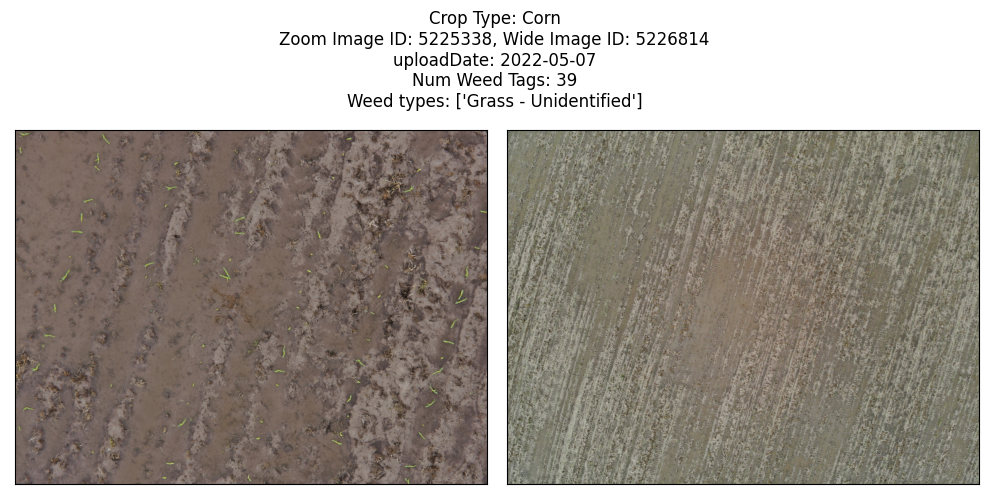

In [11]:
# SHOW ONE COUPLE BY ZOOM IMAGE ID

# example_image_id = 8488573
example_image_id = 5225338
print(f"Zoom image id: {example_image_id}")
# image_data = top_weeds_df[top_weeds_df['imageID'] == example_image_id].reset_index()
image_data = images_df[images_df['imageID'] == example_image_id].reset_index()
image_data['wideImageID'] = env.eti_api.get_matching_wide_images([example_image_id])
matching_wide_image_id = int(image_data.at[0, 'wideImageID'])
print(f"Wide image id: {matching_wide_image_id}")
image_num_tags = image_data.at[0, 'num_weed_tags']
image_crop_name = image_data.at[0, 'cropName']
upload_date = image_data.at[0, 'uploadDate_date']
weed_types = image_data.at[0, 'weed_types_ids_list']
weed_types = list(map(cat_dict_names.get, weed_types))


im_path = env.download_image(int(example_image_id))
image = io.imread(im_path)

wide_im_path = env.download_image(int(matching_wide_image_id))
wide_image = io.imread(wide_im_path)

fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(image, extent=[0, image.shape[1], 0, image.shape[0]])
axes[1].imshow(wide_image, extent=[0, wide_image.shape[1], 0, wide_image.shape[0]])


for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
fig.set_size_inches(10, 5)
plt.suptitle(f"Crop Type: {image_crop_name}\nZoom Image ID: {example_image_id}, Wide Image ID: {matching_wide_image_id}\nuploadDate: {upload_date}\nNum Weed Tags: {image_num_tags}\nWeed types: {weed_types}")
plt.tight_layout()
plt.show()

# Dataloop 

In [ ]:
# UPLOAD TO BUCKET FOR DATALOOP
import shutil

# df_to_dataloop = pd.read_csv(os.path.join(DATA_DIR, "weeds_chosen_wide_images_full.csv"))
df_to_dataloop =  pd.read_csv(os.path.join(DATA_DIR, "final_team_tagging_task_df.csv"))

# MAKE SURE ALL THE IMAGES IN FINAL_DF EXISTS IN LOCAL FOLDER
existing_images_list = glob.glob(os.path.join("images", "*.jpg"))
check_list = []
for im_id in df_to_dataloop['wideImageID']:
    if os.path.join("images", f"{im_id}.jpg"):
        check_list.append(True)

print(np.count_nonzero(check_list))


# MOVE CHOSEN IMAGES TO A FOLDER
source_folder = "images"
destination_folder = "images_to_dataloop_ttt"

# Move the file
destination_sub_folder = os.path.join(destination_folder, f"wide")
for im_id in df_to_dataloop['wideImageID']:
    source_path = os.path.join(source_folder, f"{int(im_id)}.jpg")
    image_destination_path = os.path.join(destination_sub_folder, f"{int(im_id)}.jpg")
    if not os.path.exists(image_destination_path):
        print(f"copying image {int(im_id)}.jpg")
        shutil.copy2(source_path, destination_sub_folder)

In [6]:
# CREATE DATAFRAME FOR TEAM TAGGING TASK - SELECT RANDOM IMAGES FROM EACH "IMAGE REASONING" TYPE 

chosen_image_ids_for_team_tagging_task = []
image_ids_to_exclude_from_dataset = []

types_of_rows = np.unique(df_to_dataloop['image_reasoning'])

selected_df = pd.DataFrame()
for value in types_of_rows:
    filtered_df = df_to_dataloop[df_to_dataloop['image_reasoning'] == value]
    chosen_row = filtered_df.sample(n=1)
    selected_df = pd.concat([selected_df, chosen_row])

# WATCH IMAGES - NOT IN THIS PIECE OF CODE (AND CHOOSE IMAGES TO INCLUDE OR EXCLUDE FROM DF)

# FILTER AND SAVE DATAFRAME
final_team_tagging_task_image_ids = [9278283, 5396859, 5980610, 5516023, 6932445, 6085060, 5420088, 7835169, 8828538, 6004222, 7578755, 6428560, 9288046, 5781739, 6004924, 7046658, 5397485, 9278153, 6084803, 7914736, 7461209, 7483624, 7073282]
final_team_tagging_task_df = df_to_dataloop[df_to_dataloop['imageID'].isin(final_team_tagging_task_image_ids)].reset_index(drop=True)
# final_team_tagging_task_df.to_csv(os.path.join(DATA_DIR, "final_team_tagging_task_df.csv"))

In [34]:
# CROP IMAGES FOR TEAM TAGGING TASK
images_to_dataloop_full_images_path = 'images_to_dataloop_ttt/wide'
images_to_dataloop_cropped_images_path = 'images_to_dataloop_ttt/wide_cropped_small'

chosen_wide_images_list = glob.glob(os.path.join(images_to_dataloop_full_images_path, "*.jpg"))
for im_path in tqdm(chosen_wide_images_list):
    im_id = int(os.path.basename(im_path).replace(".jpg", ""))
    image = io.imread(im_path)
    height, width, _ = image.shape

    crop_height = height // 2
    crop_width = width // 2

    cropped_image_1 = image[:crop_height, :crop_width, :]
    cropped_image_2 = image[:crop_height, crop_width:, :]
    cropped_image_3 = image[crop_height:, :crop_width, :]
    cropped_image_4 = image[crop_height:, crop_width:, :]
    
    io.imsave(os.path.join(images_to_dataloop_cropped_images_path, f'{im_id}_cropped_image_1.jpg'), cropped_image_1)
    io.imsave(os.path.join(images_to_dataloop_cropped_images_path, f'{im_id}_cropped_image_2.jpg'), cropped_image_2)
    io.imsave(os.path.join(images_to_dataloop_cropped_images_path, f'{im_id}_cropped_image_3.jpg'), cropped_image_3)
    io.imsave(os.path.join(images_to_dataloop_cropped_images_path, f'{im_id}_cropped_image_4.jpg'), cropped_image_4)


100%|██████████| 23/23 [00:33<00:00,  1.44s/it]


In [49]:
# CROP IMAGES FOR TEAM TAGGING TASK - SMALLER

N = 4

images_to_dataloop_full_images_path = 'images_to_dataloop_ttt/wide'
images_to_dataloop_cropped_images_path = 'images_to_dataloop_ttt/wide_ttt_cropped_small'

chosen_wide_images_list = glob.glob(os.path.join(images_to_dataloop_full_images_path, "*.jpg"))
for im_path in tqdm(chosen_wide_images_list):
    im_id = int(os.path.basename(im_path).replace(".jpg", ""))
    image = Image.open(im_path)
    height, width = image.size

    # image = io.imread(im_path)
    # height, width, _ = image.shape

    # crop_height = height // N
    # crop_width = width // N
    
    crop_width = image.width // N
    crop_height = image.height // N

    cnt = 0
    for i in range(N):
        for j in range(N):
            left = i * crop_width
            top = j * crop_height
            right = left + crop_width
            bottom = top + crop_height

            cropped_image = image.crop((left, top, right, bottom))
            # io.imsave(os.path.join(images_to_dataloop_cropped_images_path, f'{im_id}_cropped_image_{cnt}.jpg'), cropped_image)
            cropped_image_path = os.path.join(images_to_dataloop_cropped_images_path, f'{im_id}_cropped_image_{cnt}.jpg')
            cropped_image.save(cropped_image_path, "JPEG")
            cnt+=1
        


100%|██████████| 23/23 [00:09<00:00,  2.54it/s]


In [45]:
image.size

(4056, 3040)